## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

sys.path.append('..')
import models_mae

### Define utils

In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

In [3]:
def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

In [4]:
from pathlib import Path
from PIL import Image
import cv2

In [5]:
## nuclei images list:
nuclei_list = list(Path('/data2/image_data_noncom/nuclei_DSB2018/stage1_train/').rglob('*/images/*.png'))

In [6]:
img_base = cv2.imread(str(nuclei_list[20]), cv2.IMREAD_UNCHANGED)

tile_x = 100
tile_y = 100
img = 0

img = img_base[tile_x:(tile_x+40),tile_y:(tile_y+40),0:3]
img = np.array(Image.fromarray(img).resize((224, 224)))
img = img/255.

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

Text(0.5, 1.0, '0.3854548286106148')

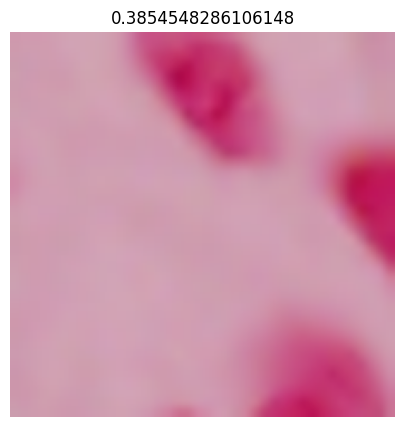

In [7]:
# load an image
#img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
#img = Image.open(requests.get(img_url, stream=True).raw)
#img = img.resize((224, 224))
#img = np.array(img) / 255.

assert img.shape == (224, 224, 3)
plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))
plt.title(np.var(img))

### Load a pre-trained MAE model

In [8]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


File ‘mae_visualize_vit_large.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


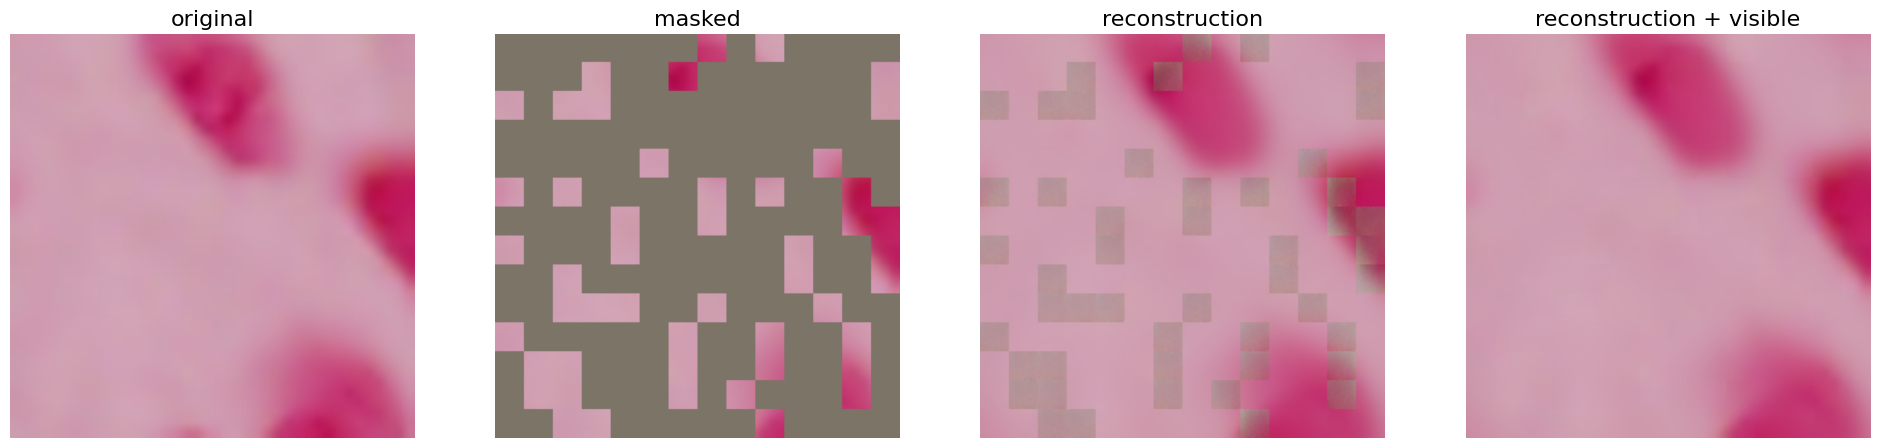

In [9]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

In [10]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model_mae.norm.register_forward_hook(get_activation('norm'))

In [11]:
x = torch.tensor(img)

# make it a batch-like
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x)

# run MAE
loss, y, mask = model_mae(x.float(), mask_ratio=0.75)
y = model_mae.unpatchify(y)
y = torch.einsum('nchw->nhwc', y).detach().cpu()

embedding = activation['norm'].detach().cpu()

In [12]:
x = torch.tensor(img)

# make it a batch-like
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x)

latent, mask, ids_restore = model_mae.forward_encoder(x.float(), 0.75)
latent = latent.detach().cpu()

x = torch.einsum('nchw->nhwc', x)

pred = model_mae.forward_decoder(latent, ids_restore)
pred = model_mae.unpatchify(pred)
pred = torch.einsum('nchw->nhwc', pred).detach().cpu()

In [13]:
## find the argmax, remove that value in the latent dims
idx_manipulate_latent = latent[0,:,:].argmax(axis = 0)[0]
latent2 = latent
latent2[:,:,idx_manipulate_latent] = -10

pred2 = model_mae.forward_decoder(latent2, ids_restore)
pred2 = model_mae.unpatchify(pred2)
pred2 = torch.einsum('nchw->nhwc', pred2).detach().cpu()

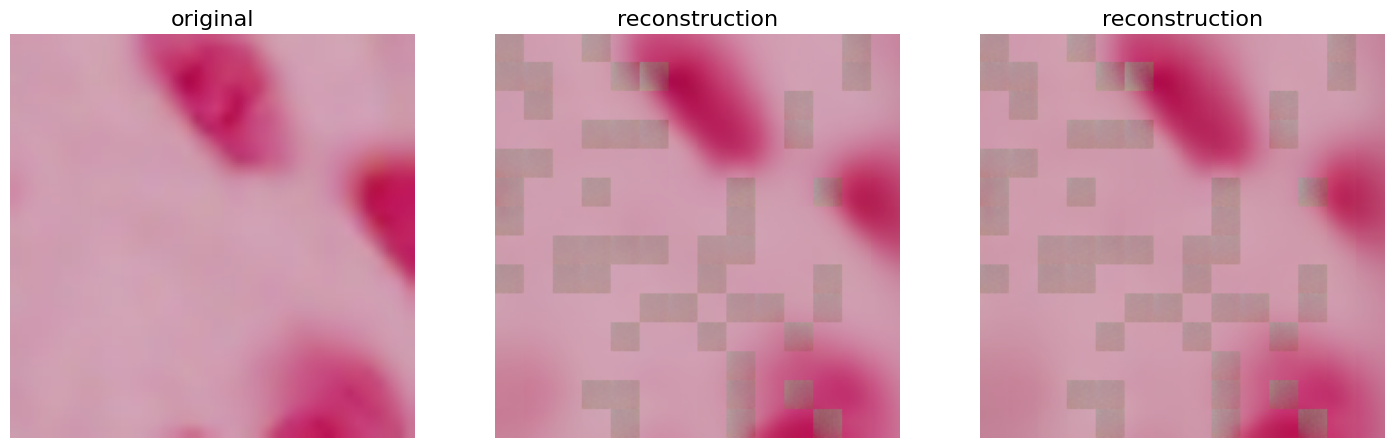

In [14]:
plt.subplot(1, 4, 1)
show_image(x[0], "original")

plt.subplot(1, 4, 2)
show_image(pred[0], "reconstruction")

plt.subplot(1, 4, 3)
show_image(pred2[0], "reconstruction")

#plt.subplot(1, 4, 4)
#show_image(im_paste[0], "reconstruction + visible")

## get some latents dimenstions from this dataset to try clustering

In [16]:
latent_arr = []

for im_idx in range(0,600,10):
    print(im_idx)

    img_base = cv2.imread(str(nuclei_list[im_idx]), cv2.IMREAD_UNCHANGED)

    img_batch = []
    for tile_x in [0,100,200]:
        for tile_y in [0,100,200]:

            img = img_base[tile_x:(tile_x+40),tile_y:(tile_y+40),0:3]
            img = np.array(Image.fromarray(img).resize((224, 224)))
            img = img/255.

            # normalize by ImageNet mean and std
            img = img - imagenet_mean
            img = img / imagenet_std

            if img.var()< 0.1:
                continue
            img_batch.append(img)

    if len(img_batch)<1: continue

    x = torch.tensor(np.stack(img_batch, axis = 0))

    # make it a batch-like
    #x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    latent, mask, ids_restore = model_mae.forward_encoder(x.float(), 0.0)

    latent = latent.detach().cpu()
    latent = latent.reshape(-1, 1024)
    latent_arr.append(latent)

    ## add processing to record the ids of the corresponding values
    #latent_ids = [im_idx, ]

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590


In [17]:
stacked_latent_dim = torch.cat(latent_arr, dim = 0)

In [19]:
import umap.umap_ as umap
reducer = umap.UMAP()

/rhome/akurniko/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
embedding_umap = reducer.fit_transform(stacked_latent_dim)
embedding_umap.shape

(30338, 2)

In [21]:
from sklearn.cluster import KMeans

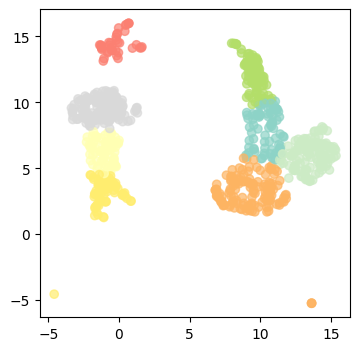

In [52]:
kmeans = KMeans(n_clusters = 8, random_state=0, n_init="auto").fit(embedding_umap)
plt.figure(figsize = (4,4))
step=40
plt.scatter(embedding_umap[::step,0], embedding_umap[::step,1], c = list(kmeans.labels_[::step]), cmap='Set3', alpha=0.7)

In [53]:
## select the average feature for a given cluster in the latent dims

cluster_latent_dim = {}
for idx in range(kmeans.n_clusters):
    rows_for_cluster = stacked_latent_dim[kmeans.labels_ == idx,:]
    idx_calc = rows_for_cluster.abs().max(axis = 0).indices
    latent_extrema = rows_for_cluster[idx_calc, range(1024)]
    cluster_latent_dim[idx] = latent_extrema

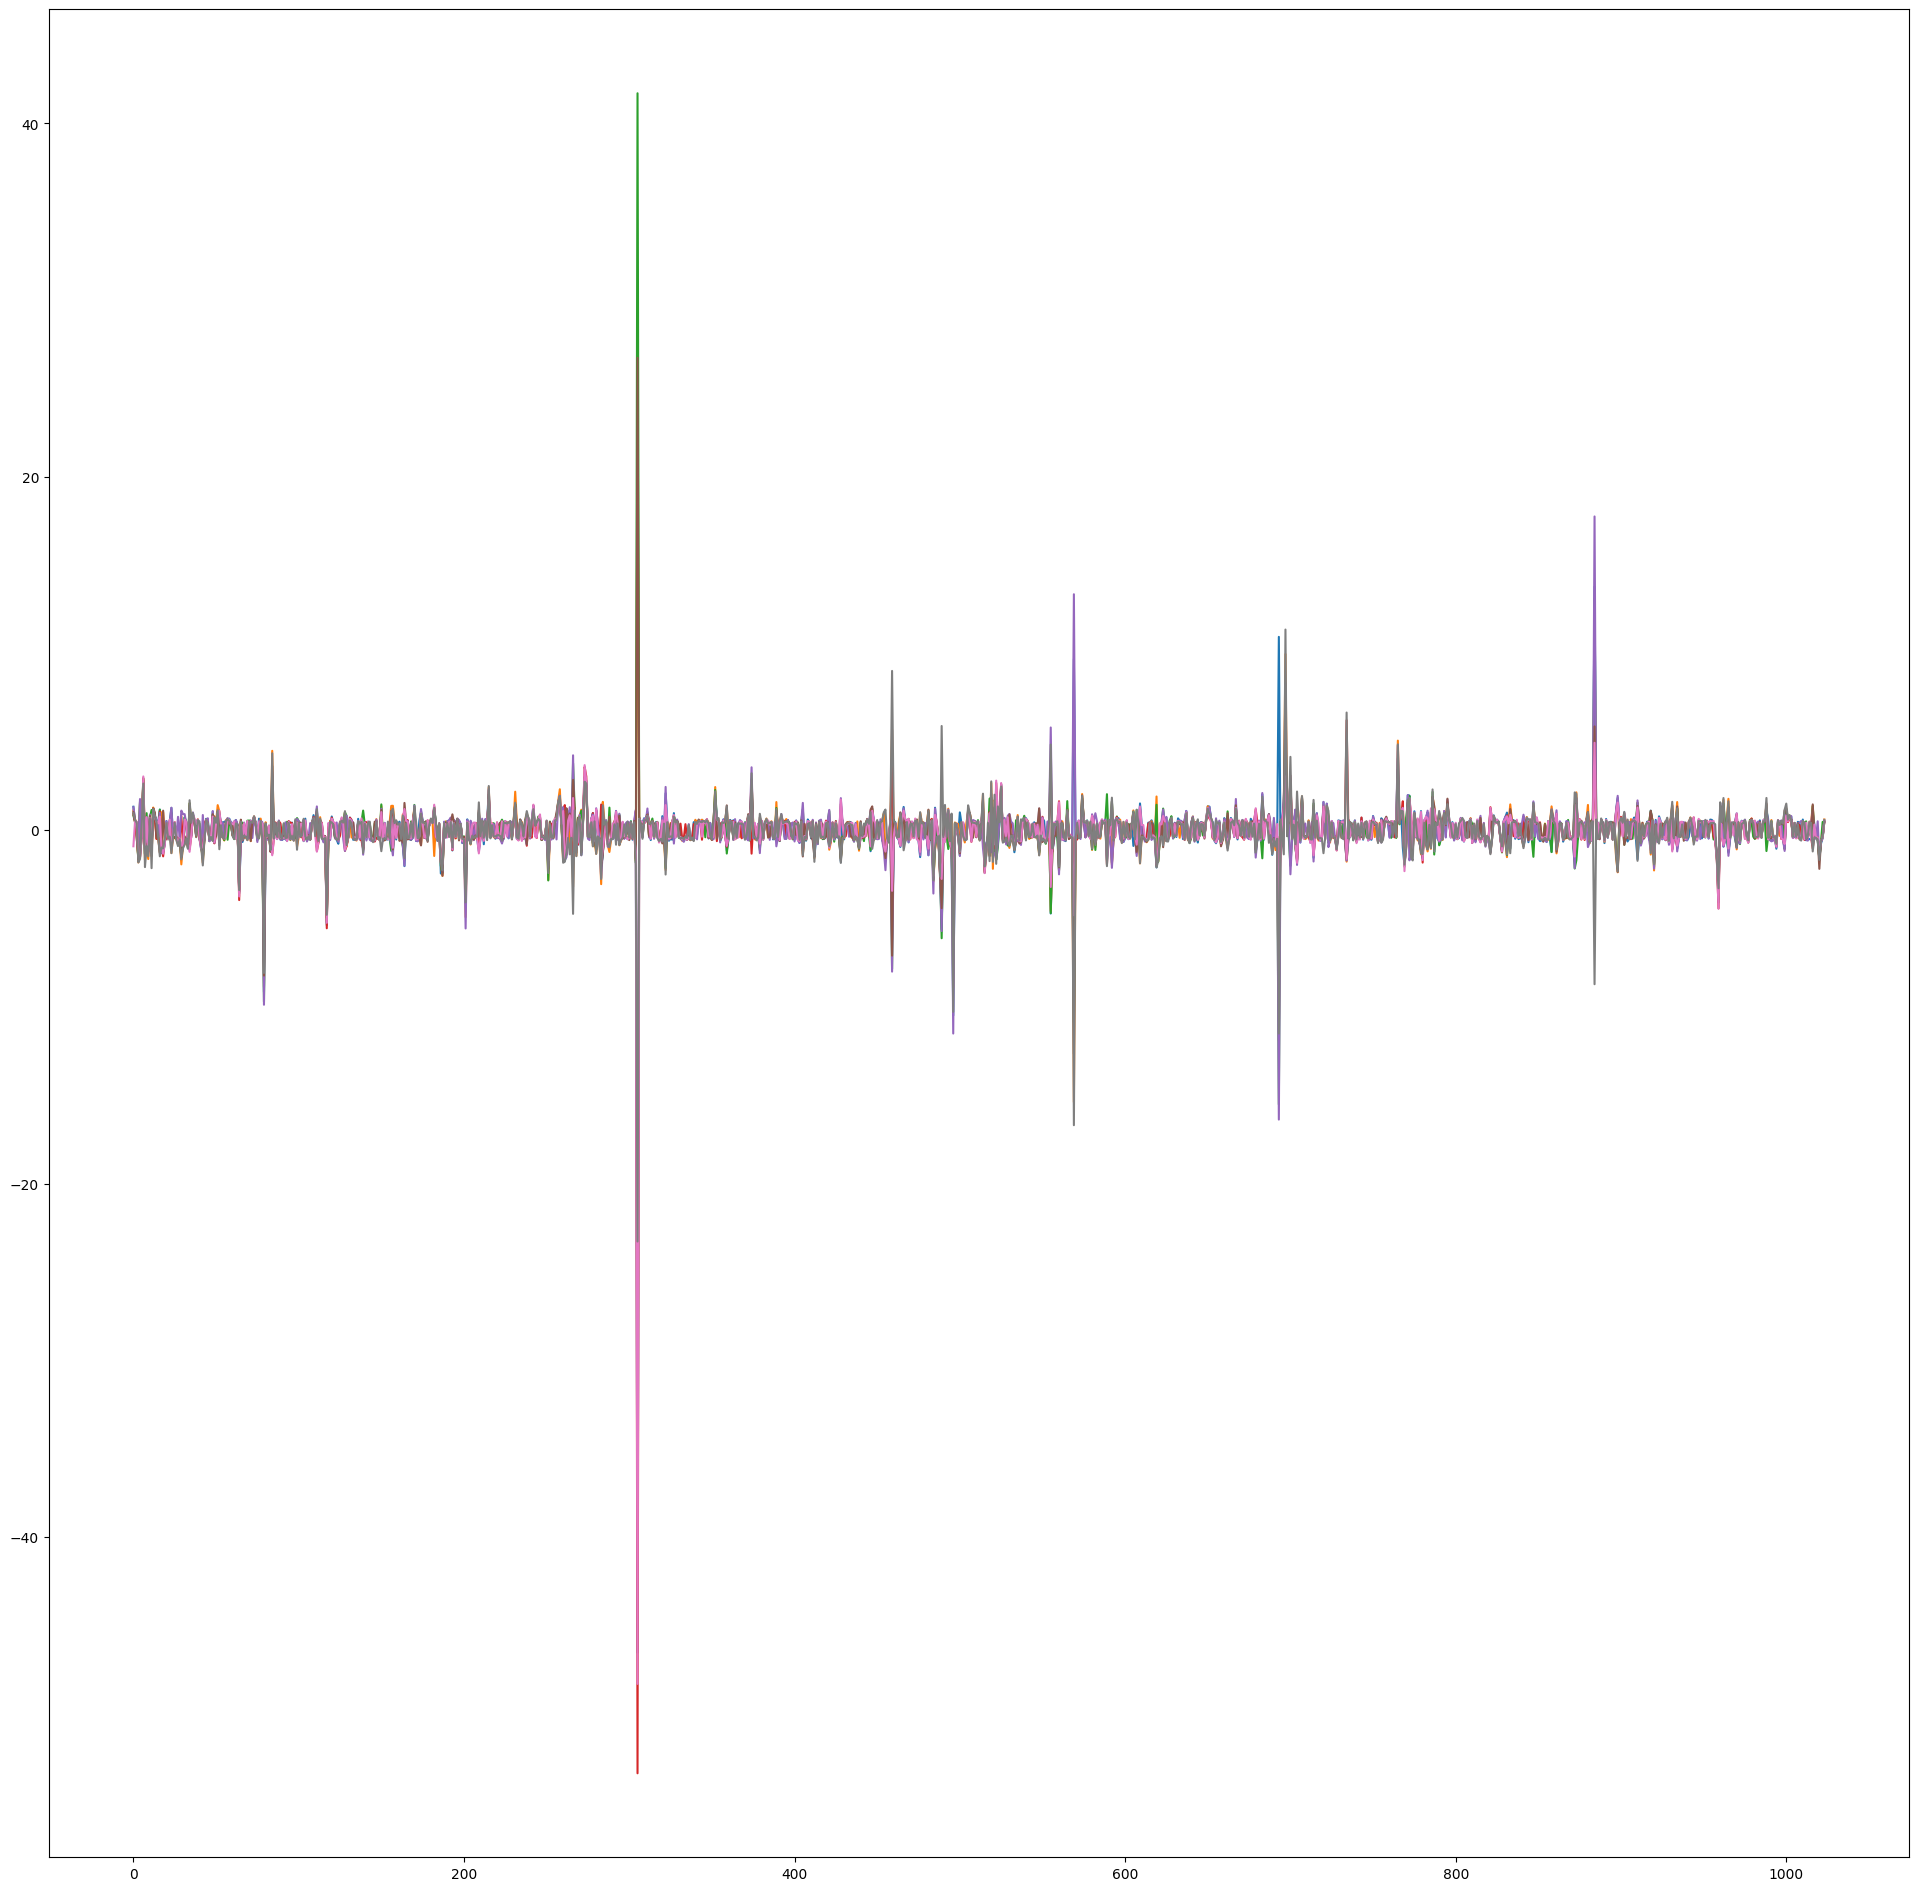

In [54]:
for idx in range(kmeans.n_clusters):
    plt.plot(cluster_latent_dim[idx])

In [60]:
x = torch.tensor(img)

# make it a batch-like
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x)

latent, mask, ids_restore = model_mae.forward_encoder(x.float(), 1.)
latent = latent.detach().cpu()

x = torch.einsum('nchw->nhwc', x)

pred = model_mae.forward_decoder(latent, ids_restore)
pred = model_mae.unpatchify(pred)
pred = torch.einsum('nchw->nhwc', pred).detach().cpu()

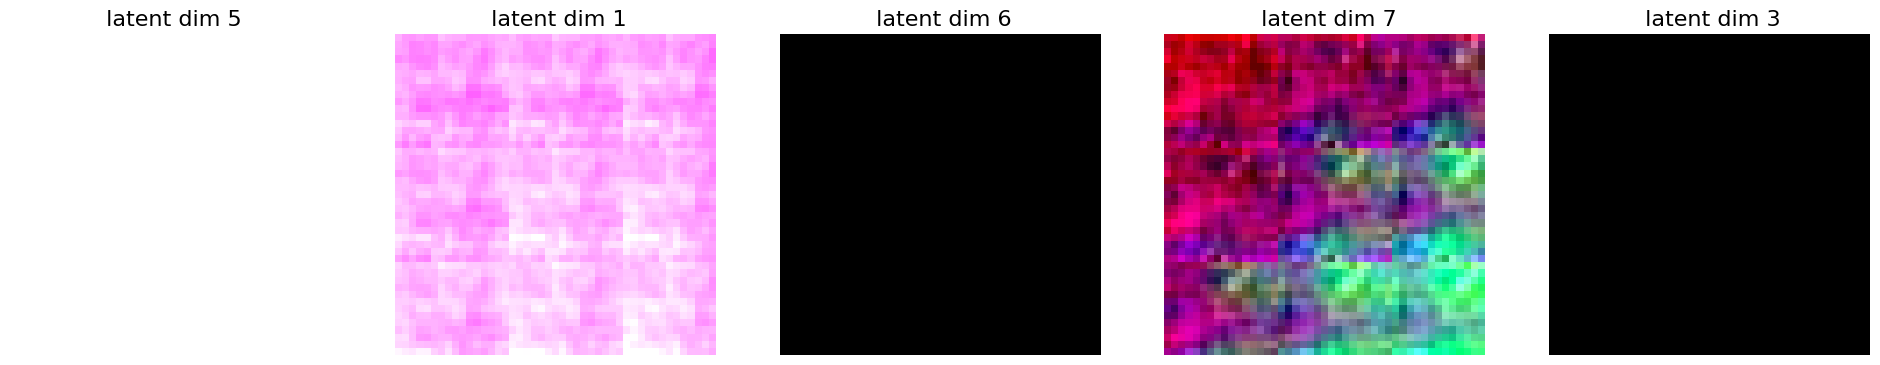

In [66]:
plot_idx = 1
for clust_idx in [5,1,6,7,3]:
    clust_latent = cluster_latent_dim[clust_idx].repeat(latent.shape[1],1).unsqueeze(dim = 0)

    pred_clust = model_mae.forward_decoder(clust_latent, ids_restore)
    pred_clust = model_mae.unpatchify(pred_clust)
    pred_clust = torch.einsum('nchw->nhwc', pred_clust).detach().cpu()

    plt.subplot(1, 5, plot_idx)
    show_image(10*pred_clust[0,:45,:45,:], f" latent dim {clust_idx}")
    plot_idx+=1

In [67]:
clust_idx = 1
clust_latent = cluster_latent_dim[clust_idx].repeat(latent.shape[1],1).unsqueeze(dim = 0)

pred_clust = model_mae.forward_decoder(clust_latent, ids_restore)
pred_clust = model_mae.unpatchify(pred_clust)
pred_clust = torch.einsum('nchw->nhwc', pred_clust).detach().cpu()


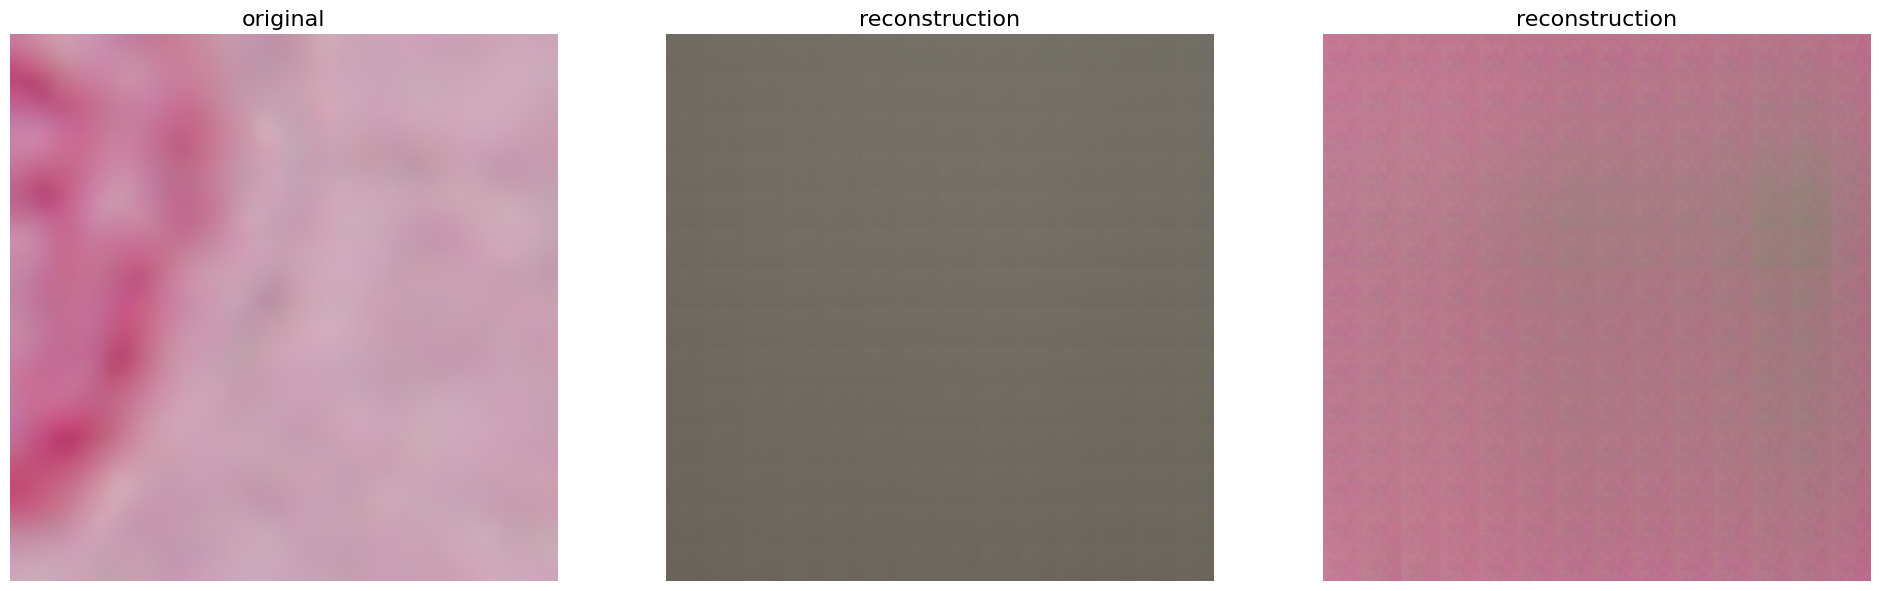

<Figure size 2400x2400 with 0 Axes>

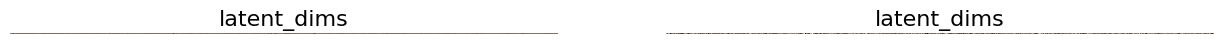

In [68]:
plt.subplot(1, 3, 1)
show_image(x[0], "original")

plt.subplot(1, 3, 2)
show_image(pred[0], "reconstruction")

plt.subplot(1, 3, 3)
show_image(pred_clust[0], "reconstruction")

plt.figure()
plt.figure()
plt.subplot(1, 3, 2)
show_image(latent[0,:,:].unsqueeze(dim = 2).repeat(1,1,3), "latent_dims")

plt.subplot(1, 3, 3)
show_image(clust_latent[0,:,:].unsqueeze(dim = 2).repeat(1,1,3), "latent_dims")


In [35]:
model_mae

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-23): 24 x Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
  (decoder_embed): Linear(in_features=1024, out_features=

In [34]:
embedding.shape

torch.Size([1, 50, 512])

In [ ]:
embedding

In [31]:
#model_mae

In [ ]:
# visualize the mask
mask = mask.detach()
mask = mask.unsqueeze(-1).repeat(1, 1, model_mae.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

x = torch.einsum('nchw->nhwc', x)

# masked image
im_masked = x * (1 - mask)

# MAE reconstruction pasted with visible patches
im_paste = x * (1 - mask) + y * mask

# make the plt figure larger
plt.rcParams['figure.figsize'] = [24, 24]

plt.subplot(1, 4, 1)
show_image(x[0], "original")

plt.subplot(1, 4, 2)
show_image(im_masked[0], "masked")

plt.subplot(1, 4, 3)
show_image(y[0], "reconstruction")

plt.subplot(1, 4, 4)
show_image(im_paste[0], "reconstruction + visible")

plt.show()

### Load another pre-trained MAE model

In [104]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

File ‘mae_visualize_vit_large_ganloss.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with extra GAN loss:


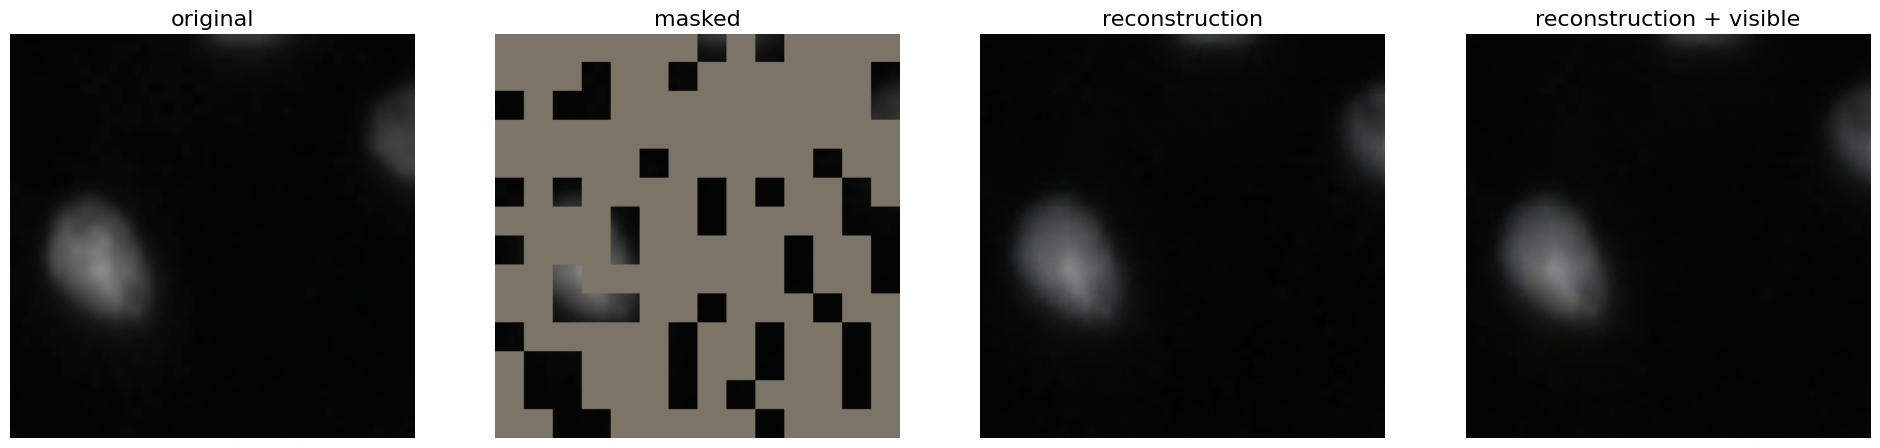

In [105]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)

In [106]:
## now lets extract the features from these models